# Traffic Sign Recognition Classifier
---
### Project from the third module of the Self-Driving Car Engineer Udacity's Nanodegree

[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)

The aim of this project is to be able to classify traffic signs that appear in 32x32x3 RGB images that can be from 43 different classes using Deep Learning. In order to do so, I will be using the data from the [**German Traffic Sign Benchmark**](http://benchmark.ini.rub.de/?section=gtsrb&subsection=news) and will be basing my approach in the **LeNet-5** architecture. The quantified target is to go over a **93% of validation accuracy**. 


# Step 0: Load The Data
---

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = '../data/train.p'
validation_file= '../data/valid.p'
testing_file = '../data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Step 1: Dataset Summary & Exploration
---
## Basic data summary

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# DONE: Number of training examples
n_train = len(X_train)

# DONE: Number of validation examples
n_validation = len(X_valid)

# DONE: Number of testing examples.
n_test = len(X_test)

# DONE: What's the shape of an traffic sign image?
image_shape = X_train[0].shape # np.ndarray of 32x32x3

# DONE: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train)) # Numeric labels going from 0 to 42 (compute counting unique elements in training outputsDONE)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


## Exploratory random data visualization
Visualize one random traffic sign and its label. The correct association can be checked using the *signnames.csv* file of this repository, which relates the numerical labels with text descriptions.

9


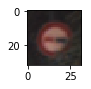

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

# DONE: Get random index to plot from the training input set
import random

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

# DONE: Plot input and output
plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

# Step 2: Design and Test the Architecture
---

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [4]:
# Shuffle the train and validation data
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)

# Normalize data (forcing a zero mean) between -1 and 1, given that the pixel range is 0-255
X_train = (X_train-128)/128
X_valid = (X_valid-128)/128
X_test = (X_test-128)/128

# TODO jmtc7 - convert to grayscale? Isnt color relevant?

### Model Architecture
#### Auxiliar function

In [5]:
import tensorflow as tf

def get_conv_layer_elements(input_size, output_size, stride, padding, mu, sigma):
    """
    Returns the necessary elements to create a convolutional layer with the received restrictions.
    
    ::param input_size:: List with two elements: [in_height (or in_width), n_channels].
    ::param output_size::  List with two elements: [out_height (or out_width), n_outputs].
    ::param stride:: Integer with the stride that will be applied in both axes (outside this func).
    ::param padding:: String with the padding type ('SAME' or 'VALID').
    ::param mu:: Mean of the normal distribution to be sampled to initialise the weights
    ::param sigma:: Standard deviation of the normal distribution to be sampled to initialise the weights
    """
    
    int_padding = int(padding=='SAME')
    
    # Extract information from requirements
    filter_size = input_size[0] + 2*int_padding - stride*(output_size[0] -1) #Same width and height
    color_channels = input_size[1]
    k_output = output_size[1]
    
    multiD_stride = [1, stride, stride, 1]
    
    # Create TensorFlow weights and biases
    weights = tf.Variable(tf.truncated_normal([filter_size, filter_size, color_channels, k_output], mean=mu, stddev=sigma))
    biases = tf.Variable(tf.zeros(k_output))
    
    return weights, biases, multiD_stride

In [6]:
#### LeNet-5 architecture

In [7]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    general_padding = 'VALID'
    
    # DONE: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    w1, b1, s1 = get_conv_layer_elements([32,3], [28,6], 1, general_padding, mu, sigma)
    conv_layer1 = tf.nn.conv2d(x, w1, s1, general_padding)
    conv_layer1 = tf.nn.bias_add(conv_layer1, b1)
    conv_layer1 = tf.nn.relu(conv_layer1)

    # DONE: Max Pooling. Input = 28x28x6. Output = 14x14x6.
    scale_fact = 2
    ksize = [1, scale_fact, scale_fact, 1]
    pool_layer2 = tf.nn.max_pool(conv_layer1, ksize, ksize, general_padding)
    
    # DONE: Layer 2: Convolutional. Output = 10x10x16.
    w3, b3, s3 = get_conv_layer_elements([14,6], [10,16], 1, general_padding, mu, sigma)
    conv_layer3 = tf.nn.conv2d(pool_layer2, w3, s3, general_padding)
    conv_layer3 = tf.nn.bias_add(conv_layer3, b3)
    conv_layer3 = tf.nn.relu(conv_layer3)

    # DONE: Max Pooling. Input = 10x10x16. Output = 5x5x16.
    scale_fact = 2
    ksize = [1, scale_fact, scale_fact, 1]
    pool_layer4 = tf.nn.max_pool(conv_layer3, ksize, ksize, general_padding)
    
    # DONE: Flatten. Input = 5x5x16. Output = 400.
    flat_pool_layer4 = flatten(pool_layer4)
    
    # DONE: Layer 3: Fully Connected. Input = 400. Output = 120.
    w5 = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma))
    b5 = tf.Variable(tf.zeros(120))
    fc_layer5 = tf.matmul(flat_pool_layer4, w5) + b5

    # DONE: Layer 4: Fully Connected. Input = 120. Output = 84.
    w6 = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma))
    b6 = tf.Variable(tf.zeros(84))
    fc_layer6 = tf.matmul(fc_layer5, w6) + b6

    # DONE: Layer 5: Fully Connected. Input = 84. Output = 43.
    w7 = tf.Variable(tf.truncated_normal(shape=(84, 43), mean=mu, stddev=sigma))
    b7 = tf.Variable(tf.zeros(43))
    fc_layer7 = tf.matmul(fc_layer6, w7) + b7
    
    return fc_layer7 #Logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

#### Setup 

In [8]:
# Hyperparameters
EPOCHS = 10
BATCH_SIZE = 128
LEARNING_RATE = 0.001

# Input and output placeholders
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

#### Training pipeline

In [9]:
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)

### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

#### Evaluation pipeline and execution function

In [10]:
# Evaluation pipeline
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

# Function to execut the evaluation given certain input and output data
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

#### Training process

In [14]:
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    # For each configure EPOCH
    for i in range(EPOCHS):
        # Mix data (again)
        X_train, y_train = shuffle(X_train, y_train)
        
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        
        # Run validation
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
    # Save ses
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.437

EPOCH 2 ...
Validation Accuracy = 0.603

EPOCH 3 ...
Validation Accuracy = 0.702

EPOCH 4 ...
Validation Accuracy = 0.708

EPOCH 5 ...
Validation Accuracy = 0.723

EPOCH 6 ...
Validation Accuracy = 0.731

EPOCH 7 ...
Validation Accuracy = 0.751

EPOCH 8 ...
Validation Accuracy = 0.760

EPOCH 9 ...
Validation Accuracy = 0.744

EPOCH 10 ...
Validation Accuracy = 0.761

Model saved


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")